In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re

### Convert YelpZip txt files into csv

In [3]:
os.chdir('/Users/john/Developer/CS175/CS175Project')

In [4]:
reviewTextFile = 'reviewContent.txt'
outcomeAndRating = 'metadata.txt'

yelpZipDir = os.path.abspath('./YelpZip')
cwd = os.getcwd()
os.chdir(yelpZipDir)

reviews, rating, real = [], [], []
ratingDist = {1:0, 2:0, 3:0, 4:0, 5:0}
generationDist = {0:0, 1:0}
with open(reviewTextFile, encoding="utf8") as f:
    for line in f:
        parts = line.rstrip('\n').split('\t')
        id = int(parts[0])-5044
        review = parts[-1].replace('\n', '')
        review = review.replace('\u200c', '')
        review = re.sub(r'[^A-Za-z0-9 ]+', '', review)
        reviews.append(review)

with open(outcomeAndRating, encoding="utf8") as f:
    i = 0
    for line in f:
        parts = line.rstrip('\n').split('\t')
        id = int(parts[0])-5044
        stars = parts[2]
        fakeOrNot = parts[3]
        rating.append(int(stars[0])) 
        real.append(0 if int(fakeOrNot) == -1 else 1)
        ratingDist[int(stars[0])]+=1
        generationDist[0 if int(fakeOrNot) == -1 else 1]+=1
        i+=1
os.chdir(cwd)
      
df = pd.DataFrame(data={"Review":reviews, "Generated": real})

df.to_csv(os.getcwd()+'/data/yelpZip.csv', index=False)

### Data About YelpZip Dataset

Rating Distribution


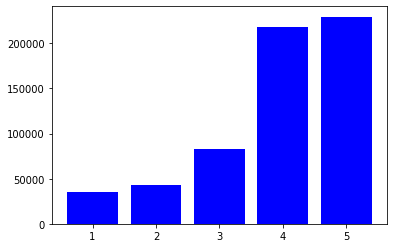

There were 35600 reviews with 1 stars. This makes up 5.849509857081357% of the reviews
There were 42985 reviews with 2 stars. This makes up 7.062954528276465% of the reviews
There were 83139 reviews with 3 stars. This makes up 13.660741573255253% of the reviews
There were 217465 reviews with 4 stars. This makes up 35.7321253109606% of the reviews
There were 229409 reviews with 5 stars. This makes up 37.69466873042632% of the reviews


In [ ]:
print("Rating Distribution")

plt.bar(ratingDist.keys(), ratingDist.values(), color='b')
plt.show()
for key in ratingDist.keys():
    print("There were", ratingDist[key], "reviews with", key,"stars. This makes up", str(ratingDist[key]/len(reviews)*100) + "% of the reviews")

Generation Distribution


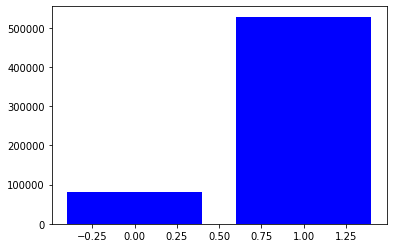

There were 80466 reviews that were flagged as spam. This makes up 13.22153539775024% of the reviews
There were 528132 reviews that were not flagged as spam. This makes up 86.77846460224976% of the reviews


In [16]:
print("Generation Distribution")

plt.bar(generationDist.keys(), generationDist.values(), color='b')
plt.show()

print("There were", generationDist[0], "reviews that were flagged as spam. This makes up", str(generationDist[0]/len(reviews)*100) + "% of the reviews")
print("There were", generationDist[1], "reviews that were not flagged as spam. This makes up", str(generationDist[1]/len(reviews)*100) + "% of the reviews")

### Convert OSF Fake Review Dataset to Standard Form

In [5]:
conversion = {"CG":0, "OR": 1}

osfDir = os.path.abspath('./OSF')
os.chdir(osfDir)

df = pd.read_csv("osfFakeReviewDataset.csv")
df.drop(columns=["category","rating"], inplace=True)
cols = df.columns.to_list()
df = df[cols[::-1]]
df.rename(columns={'text_':"Review",'label':"Generated"}, inplace=True)
print(df.columns.to_list())

ratingDist = {1:0, 2:0, 3:0, 4:0, 5:0}
generationDist = {0:0, 1:0}
l = 0
for i, row in df.iterrows():
    df.at[i,'Generated'] = conversion[df.at[i,'Generated']]
    review = df.at[i, "Review"].replace('\n', '')
    review = review.replace('\u200c', '')
    review = re.sub(r'[^A-Za-z0-9 ]+', '', review)
    df.at[i,"Review"] = review
    #ratingDist[df.at[i,'Rating']] += 1
    generationDist[df.at[i,'Generated']] += 1
    l+=1
os.chdir(cwd)
df.to_csv(os.getcwd()+'/data/OSF.csv', index=False)

['Review', 'Generated']


In [27]:
os.chdir(cwd)

Generation Distribution


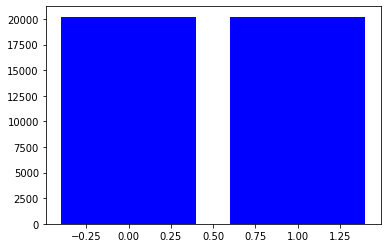

There were 20216 reviews that were flagged as spam. This makes up 50.0% of the reviews
There were 20216 reviews that were not flagged as spam. This makes up 50.0% of the reviews


In [47]:
print("Generation Distribution")

plt.bar(generationDist.keys(), generationDist.values(), color='b')
plt.show()

print("There were", generationDist[0], "reviews that were flagged as spam. This makes up", str(generationDist[0]/l*100) + "% of the reviews")
print("There were", generationDist[1], "reviews that were not flagged as spam. This makes up", str(generationDist[1]/l*100) + "% of the reviews")

### Combine DataSets

In [16]:
dataDir = os.path.abspath("./data")
cwd = os.getcwd()

os.chdir(dataDir)
osfDF = pd.read_csv(os.getcwd() + "/OSF.csv")
yelpZipDF = pd.read_csv(os.getcwd() + "/yelpZip.csv")

comb = pd.concat([osfDF, yelpZipDF], ignore_index=True)
comb.to_csv(os.getcwd()+"/combinedCSV.csv", index = False)
os.chdir(cwd)

### Combined Dataset

In [8]:
from sklearn.model_selection import train_test_split

train_size = 0.6

X = comb.drop(columns=['Generated']).copy()
y = comb['Generated']

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=train_size)

test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=test_size)

train = pd.concat([X_train, y_train], axis = 1)
valid = pd.concat([X_test, y_test], axis = 1)
test = pd.concat([X_valid, y_valid], axis = 1)

try:
    train.to_csv(os.getcwd()+"/partitions/train.csv", index = False)
    valid.to_csv(os.getcwd()+"/partitions/valid.csv", index = False)
    test.to_csv(os.getcwd()+"/partitions/test.csv", index = False)
except:
    pass

In [9]:
y.value_counts()

1    548348
0    100682
Name: Generated, dtype: int64

### Oversampled Dataset

In [56]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
ros.fit(X_valid, y_valid)
X_valid_resampled, y_valid_resampled = ros.fit_resample(X_valid, y_valid)

train = pd.concat([X_train_resampled, y_train_resampled], axis = 1)
valid = pd.concat([X_test, y_test], axis = 1)
test = pd.concat([X_valid_resampled, y_valid_resampled], axis = 1)

try:
    train.to_csv(os.getcwd()+"/partitions/oversampledTrain.csv", index = False)
    valid.to_csv(os.getcwd()+"/partitions/oversampledValid.csv", index = False)
    test.to_csv(os.getcwd()+"/partitions/oversampledTest.csv", index = False)
except:
    pass

In [57]:
y_train_resampled.value_counts()

1    329094
0    329094
Name: Generated, dtype: int64

### Undersampled Dataset

In [58]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=0)
ros.fit(X_train, y_train)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
ros = RandomUnderSampler(random_state=0)
ros.fit(X_valid, y_valid)
X_valid_resampled, y_valid_resampled = ros.fit_resample(X_valid, y_valid)

train = pd.concat([X_train_resampled, y_train_resampled], axis = 1)
valid = pd.concat([X_test, y_test], axis = 1)
test = pd.concat([X_valid_resampled, y_valid_resampled], axis = 1)


try:
    train.to_csv(os.getcwd()+"/partitions/undersampledTrain.csv", index = False)
    valid.to_csv(os.getcwd()+"/partitions/undersampledValid.csv", index = False)
    test.to_csv(os.getcwd()+"/partitions/undersampledTest.csv", index = False)
except:
    pass

In [59]:
y_train_resampled.value_counts()

0    60324
1    60324
Name: Generated, dtype: int64

### Small Datasets

In [34]:
from sklearn.model_selection import train_test_split
X = comb.drop(columns=['Generated']).copy()
y = comb['Generated']

train_size = 0.99938
X_l, X_s, y_l, y_s = train_test_split(X, y, train_size=train_size)

smallSet = pd.concat([X_s, y_s], axis = 1)
print(y_s.value_counts())
try:
    smallSet.to_csv(os.getcwd()+"/partitions/smallCombinedTest.csv", index = False)
except:
    pass

1    333
0     70
Name: Generated, dtype: int64


In [30]:
X = osfDF.drop(columns=['Generated']).copy()
y = osfDF['Generated']
train_size = 0.99
X_l, X_s, y_l, y_s = train_test_split(X, y, train_size=train_size)

smallSet = pd.concat([X_s, y_s], axis = 1)
print(y_s.value_counts())
try:
    smallSet.to_csv(os.getcwd() + "/partitions/smallOSFTest.csv", index=False)
except:
    pass

1    209
0    196
Name: Generated, dtype: int64


### RNN train and test

In [1]:
	# train_charRNN(20000, 0.01)
	# predict("Hanzawa")
	# predict("Jackson")


### Accuracy visualization

C:\Users\trung\AppData\Local\Temp/ipykernel_16476/2606101778.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+numNodes)
C:\Users\trung\AppData\Local\Temp/ipykernel_16476/2606101778.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+hidLayers)


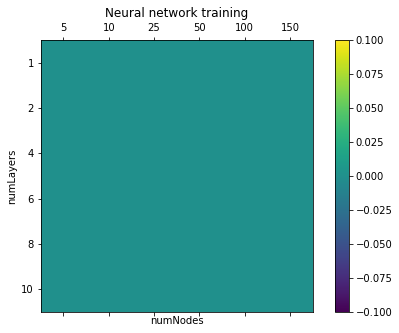

C:\Users\trung\AppData\Local\Temp/ipykernel_16476/2606101778.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+numNodes)
C:\Users\trung\AppData\Local\Temp/ipykernel_16476/2606101778.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+hidLayers)


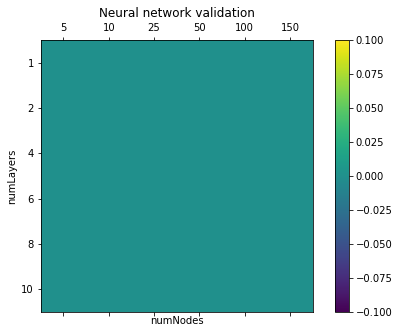

In [13]:
hidLayers=[1,2,4,6,8,10]
numNodes=[5,10,25,50,100,150]
trAcc = [[0]*len(hidLayers)]*len(numNodes)
vaAcc = [[0]*len(hidLayers)]*len(numNodes)

for i,k in enumerate(hidLayers):
    for j,a in enumerate(numNodes):
        #clf = MLPClassifier(solver='sgd', alpha=1e-5,hidden_layer_sizes=tuple([a]*k), random_state=1)
        #clf.fit(X_train,Y_train)
        #trAcc[i][j] = accuracy_score(Y_train, clf.predict(X_train))
        #vaAcc[i][j] = accuracy_score(Y_test, clf.predict(X_test))
        pass

f, ax = plt.subplots(1, 1, figsize=(8, 5))
cax = ax.matshow(trAcc, interpolation='nearest')
f.colorbar(cax)
ax.set_xticklabels(['']+numNodes)
ax.set_yticklabels(['']+hidLayers)
plt.title('Neural network training')
plt.xlabel('numNodes')
plt.ylabel('numLayers')
plt.show()

f, ax = plt.subplots(1, 1, figsize=(8, 5))
cax = ax.matshow(vaAcc, interpolation='nearest')
f.colorbar(cax)
ax.set_xticklabels(['']+numNodes)
ax.set_yticklabels(['']+hidLayers)
plt.title('Neural network validation')
plt.xlabel('numNodes')
plt.ylabel('numLayers')
plt.show()